In [1]:
import sys
sys.path.append('../marketools')

In [2]:
from marketools import Stock, store_data
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
sn.set()
store_data()

In [3]:
ticker = 'WIG'
stagnetion_delta = 0.2  # %, maximum amplitude (+/-) of price during stagnation
volume_delta = 0.5  # relative change of volume before the day of prediction, (1+-volume_delta) is used to determine if volume change is LOW, NORM, or HIGH
short_window = 4  # number of days considered by algorith before the day the prediction is made for (also window for volume short moving average)
long_window = 90  # window for volume long moving average
min_confidence = 0.35  # minimum required confidence of output state
interval = 'd'  # interval for OHLC data

In [4]:
stk = Stock(ticker)
stk.interval = interval
data = stk.ohlc.drop(['High', 'Low'], axis=1)

window = short_window

data['Change%'] = 100 * (data['Close'] - data['Open']) / data['Open']
data[f'Volume {window}d mean'] = data['Volume'].rolling(window).mean()
data[f'Volume {long_window}d mean'] = data['Volume'].rolling(long_window).mean()
data['Volume change'] = data[f'Volume {window}d mean'] / data[f'Volume {long_window}d mean']

# Labeling volume
LOW = 0
NORM = 1
HIGH = 2

data['Volume state'] = NORM
data.loc[data['Volume change'] < (1-volume_delta), 'Volume state'] = LOW
data.loc[data['Volume change'] > (1+volume_delta), 'Volume state'] = HIGH

# Volume state should describes volume relative change for the day before
data['Volume state'] = data['Volume state'].shift(1)

# Labeling the market: 
BEARISH = 0
STAGNATION = 1
BULLISH = 2

data['Market'] = STAGNATION
data.loc[data['Change%'] > stagnetion_delta, 'Market'] = BULLISH
data.loc[data['Change%'] < -stagnetion_delta, 'Market'] = BEARISH

"""
Numeric value describing state of the market based on given number of days before the day of prediction (window).
Decimal representation of ternary suber that directly describes the market before the day, e.g,
102 means that 3 days ago the market was bullish (1), 2 days ago - bearish, and 1 day ago there was stagnetion
"""
data['Market state'] = 0

for w in range(1, window+1):
    data[f'Market {w}d before'] = data['Market'].shift(w)
    data['Market state'] += pow(3, w-1) * data[f'Market {w}d before']

# Taking volume into account for market state
data['Market state'] += pow(3, window) * data['Volume state']
window = window + 1
    
data.drop(data.head(long_window).index,inplace=True)
data['Market state'] = data['Market state'].astype('int')

# Extracting validation set
data_valid = data['2019-01-01':]
data = data['2001-01-01':'2018-12-31']
data

,Open,Close,Volume,Change%,Volume 4d mean,Volume 90d mean,Volume change,Volume state,Market,Market state,Market 1d before,Market 2d before,Market 3d before,Market 4d before
Date,,,,,,,,,,,,,,
2001-01-02,17567.90,17672.80,4935736.0,0.597112,5614102.00,4.959242e+06,1.132048,1.0,2,154,1.0,0.0,2.0,2.0
2001-01-03,17520.70,17506.10,8818742.0,-0.083330,6493357.25,5.013187e+06,1.295255,1.0,1,140,2.0,1.0,0.0,2.0
2001-01-04,17673.00,17875.90,8597278.0,1.148079,7262866.25,5.069466e+06,1.432669,1.0,2,97,1.0,2.0,1.0,0.0
2001-01-05,17862.30,17509.30,8211943.0,-1.976229,7640924.75,5.135885e+06,1.487752,1.0,0,131,2.0,1.0,2.0,1.0
2001-01-08,17276.70,17119.30,7374110.0,-0.911054,8250518.25,5.187991e+06,1.590311,1.0,0,150,0.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-19,58695.35,59223.65,84523487.0,0.900071,74520325.25,5.633193e+07,1.322879,1.0,2,155,2.0,0.0,2.0,2.0
2018-12-20,58646.01,58349.03,64835691.0,-0.506394,70336191.75,5.657141e+07,1.243317,1.0,0,143,2.0,2.0,0.0,2.0
2018-12-21,58188.73,57331.35,111132639.0,-1.473447,85570300.75,5.734942e+07,1.492087,1.0,0,105,0.0,2.0,2.0,0.0


In [5]:
data_valid['Predicted market'] = np.nan
data_valid

,Open,Close,Volume,Change%,Volume 4d mean,Volume 90d mean,Volume change,Volume state,Market,Market state,Market 1d before,Market 2d before,Market 3d before,Market 4d before,Predicted market
Date,,,,,,,,,,,,,,,
2019-01-02,57494.06,58290.21,25417940.0,1.384752,53351501.50,5.681792e+07,0.938991,1.0,2,83,2.0,0.0,0.0,0.0,NaN
2019-01-03,58055.17,57192.42,30761455.0,-1.486086,33258705.50,5.659438e+07,0.587668,1.0,0,89,2.0,2.0,0.0,0.0,NaN
2019-01-04,57489.96,57947.51,33530663.0,0.795878,31811193.50,5.638678e+07,0.564161,1.0,2,105,0.0,2.0,2.0,0.0,NaN
2019-01-07,58270.90,58971.42,39923428.0,1.202178,32408371.50,5.623611e+07,0.576291,1.0,2,155,2.0,0.0,2.0,2.0,NaN
2019-01-08,58884.37,58906.77,37751792.0,0.038041,35491834.50,5.627077e+07,0.630733,1.0,1,143,2.0,2.0,0.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,58486.64,58157.32,53361400.0,-0.563069,81910197.75,6.369232e+07,1.286030,1.0,0,136,1.0,0.0,0.0,2.0,NaN
2021-02-23,58383.46,57029.17,88258835.0,-2.319647,87534078.50,6.417504e+07,1.363989,1.0,0,84,0.0,1.0,0.0,0.0,NaN
2021-02-24,57182.54,57596.33,72323167.0,0.723630,73018446.00,6.445237e+07,1.132906,1.0,2,90,0.0,0.0,1.0,0.0,NaN


In [6]:
transition_matrix = np.zeros((3, 3**window))  # state[k+1] = transition_matrix.dot(state[k])

"""
Calculating transition matrix: horizontal axis - known state of the market, vertical axis - possible markets to predict.
i - input market state, j - output market state (0, 1, 2)
"""
for i in range(0, 3**window):
    n = data.loc[(data['Market state'] == i)].shape[0]  # count of input paterns
    
    for j in range(0, 3):
        if 0 == n:
            transition_matrix[j, i] = 1 / 3  # pattern have not appear, assume equal probability for all outputs
        else:
            transition_matrix[j, i] = data.loc[(data['Market'] == j) & (data['Market state'] == i)].shape[0] / n

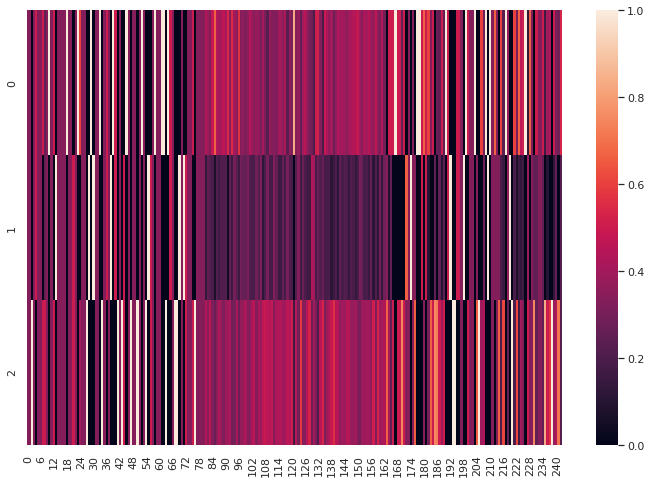

In [7]:
sn.heatmap(transition_matrix)
plt.show()

In [8]:
# Checking performance
for index, row in data_valid.iterrows():
    market_state = np.zeros(3**window)  
    market_state[int(row['Market state'])] = 1  # input market state
    prediction_vector = transition_matrix.dot(market_state)
    if np.amax(prediction_vector) >= min_confidence:
        data_valid.loc[index, 'Predicted market'] = prediction_vector.argmax()
    
data_valid['Correct prediction'] = data_valid['Market'] == data_valid['Predicted market']
data_valid.dropna(inplace=True)

In [9]:
summary_table = pd.DataFrame(
    [data_valid.loc[data_valid['Market'] == BULLISH, 'Correct prediction'].value_counts(),
     data_valid.loc[data_valid['Market'] == BEARISH, 'Correct prediction'].value_counts(),
     data_valid.loc[data_valid['Market'] == STAGNATION, 'Correct prediction'].value_counts(),
     data_valid['Correct prediction'].value_counts()],
    ['Bullish market', 'Bearish market', 'Stagnation', 'Total']
)
summary_table

,True,False
Bullish market,92,87
Bearish market,122,121
Stagnation,1,114
Total,215,322


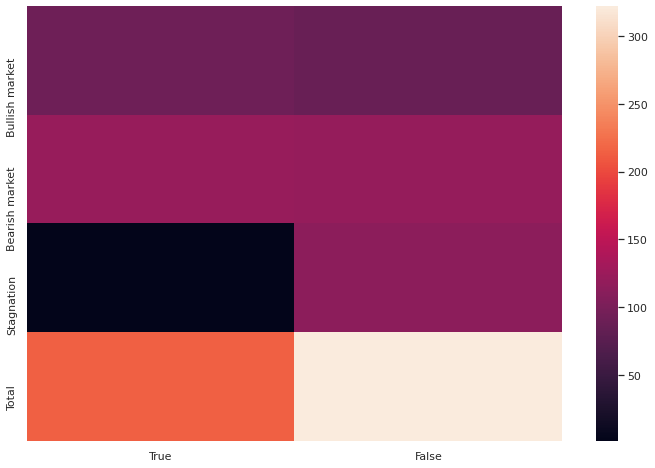

In [10]:
sn.heatmap(summary_table)
plt.show()